# Practica Modulo Machine Learning -- Daniel Alvaro

En este notebook vamos a abordar la práctica del modulo de Machine Learning siguiendo los siguientes pasos.

1. Generación de nuevas características a partir de las existentes
2. Codificación de variables
3. Análisis exploratorio
4. Selección y evaluación del modelo
5. Comparativa de distintos algoritmos

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [2]:
full_airbnb = pd.read_csv('./data/airbnb-listings.csv',sep=';', decimal='.')

In [3]:
full_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
ID                                14780 non-null int64
Listing Url                       14780 non-null object
Scrape ID                         14780 non-null int64
Last Scraped                      14780 non-null object
Name                              14779 non-null object
Summary                           14189 non-null object
Space                             10888 non-null object
Description                       14774 non-null object
Experiences Offered               14780 non-null object
Neighborhood Overview             9134 non-null object
Notes                             5644 non-null object
Transit                           9066 non-null object
Access                            8318 non-null object
Interaction                       8228 non-null object
House Rules                       9619 non-null object
Thumbnail Url                     11960 non-null object
Med

Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host

In [4]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* Square Feet: Contiene 14182 observaciones null
* Weekly Price: Contiene 11190 observaciones null
* Monthly Price: Contiene 11219 obsevaciones null
* Has Availability: Contiene 12768 observaciones null
* First Review: No creemos que aporte informacion util para el calculo del precio
* Last Review: No creemos que aporte informacion util para el calculo del precio
* Calendar Updated: No creemos que aporte informacion util para el calculo del precio
* License: Contiene 14431 observaciones null
* Bed Type: Casi el 99% de las camas son del mismo tipo (Real Bed)



In [5]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


In [6]:
full_airbnb.shape

(14780, 29)

**Tras la limpeza inicial nos hemos quedado con 28 caracteristicas.**

## Separación Train Test

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De momento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 29)
Dimensiones del dataset de test: (2956, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [8]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

449
0
Embajadores                                                                       1476
Universidad                                                                       1059
Palacio                                                                            881
Sol                                                                                769
Justicia                                                                           630
Cortes                                                                             607
Trafalgar                                                                          253
Argüelles                                                                          216
Palos de Moguer                                                                    215
Goya                                                                               190
Puerta del Angel                                                                   151
Guindalera                           

In [9]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

49
819
Centro                      5422
Chamberí                     763
Salamanca                    721
Arganzuela                   631
Tetuán                       373
Retiro                       361
Moncloa - Aravaca            358
Latina                       291
Chamartín                    284
Carabanchel                  284
Ciudad Lineal                257
Puente de Vallecas           174
Hortaleza                    142
Fuencarral - El Pardo        129
Usera                        120
Eixample                      97
San Blas - Canillejas         92
Barajas                       67
Villaverde                    65
Moratalaz                     58
Villa de Vallecas             39
Ciutat Vella                  37
Sants-Montjuïc                32
Gràcia                        31
Vicálvaro                     31
Manhattan                     28
Brooklyn                      21
Les Corts                     12
Isole                         12
Friedrichshain-Kreuzberg      12
San

A la vista de los datos anteriores tenemos la siguiente informacio:
- La variable "Neighbourhood Cleansed" contiene 449 categorias y ningun valor null. Nos quedaremos con aquellas categorias que tienen mas de 50 apartamentos y el resto iran a la categoria de Other. Obtenemos 43 categorias.
- La variable "Neighbourhood Group Cleansed contiene 49 categorias y 819 celdas null. Igual que en el caso anterior nos quedaremos con aquellas categorias de mas de 50 pisos y el resto incluyendo los nullos iran a la categoria Others. El problema es que solo poniendo los nulos como "other" esta categoria ya se convierte en la segunda con mas frecuencia. Obtenemos 21 categorias

In [10]:
neig_tmp = train['Neighbourhood Cleansed']
#Extraemos el vector con las frecuencias de cada barrio
freqs = neig_tmp.value_counts()
#Extraemos el vector con los barrios que seran reemplazados por "Other" en funcion de una frecuencia minima
min_freq = 50
freqs_replace = freqs[freqs<=min_freq].index
neig_tmp = neig_tmp.replace(freqs_replace, 'Other')
train['Neighbourhood Cleansed'] = neig_tmp
print('El numero de categorias es :', len(neig_tmp.unique()))
with pd.option_context("display.max_rows", 1000):
    print(neig_tmp.value_counts())

El numero de categorias es : 43
Other                2786
Embajadores          1476
Universidad          1059
Palacio               881
Sol                   769
Justicia              630
Cortes                607
Trafalgar             253
Argüelles             216
Palos de Moguer       215
Goya                  190
Puerta del Angel      151
Guindalera            144
Recoletos             140
Arapiles              137
Almagro               124
Acacias               119
Pacífico              117
Gaztambide            111
Lista                 108
Cuatro Caminos        104
Delicias               96
Chopera                90
Castellana             85
Rios Rosas             84
Ibiza                  83
Prosperidad            77
San Isidro             71
Jerónimos              70
San Diego              67
Imperial               67
Ventas                 66
Castillejos            65
Bellas Vistas          65
Palma de Mallorca      59
Hispanoamérica         59
Vista Alegre           59
Casa d

In [11]:
neig_group_tmp = train['Neighbourhood Group Cleansed']
#Extraemos el vector con las frecuencias de cada barrio
freqs = neig_group_tmp.value_counts()
#Extraemos el vector con los barrios que seran reemplazados por "Other" en funcion de una frecuencia minima
min_freq = 50
freqs_replace = freqs[freqs<=min_freq].index
neig_group_tmp = neig_group_tmp.replace(freqs_replace, 'Other')
#por ultimo ponemos los NaN tambien a "Other"
neig_group_tmp.fillna("Other", inplace=True)
train['Neighbourhood Group Cleansed'] = neig_group_tmp
print('El numero de categorias es :', len(neig_group_tmp.unique()))
print(neig_group_tmp.isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(neig_group_tmp.value_counts())

El numero de categorias es : 21
0
Centro                   5422
Other                    1135
Chamberí                  763
Salamanca                 721
Arganzuela                631
Tetuán                    373
Retiro                    361
Moncloa - Aravaca         358
Latina                    291
Chamartín                 284
Carabanchel               284
Ciudad Lineal             257
Puente de Vallecas        174
Hortaleza                 142
Fuencarral - El Pardo     129
Usera                     120
Eixample                   97
San Blas - Canillejas      92
Barajas                    67
Villaverde                 65
Moratalaz                  58
Name: Neighbourhood Group Cleansed, dtype: int64


A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [12]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9601
House                 1074
Condominium            288
Bed & Breakfast        275
Loft                   247
Other                  181
Dorm                    35
Guesthouse              32
Chalet                  19
Townhouse               15
Hostel                  14
Villa                   13
Serviced apartment       9
Casa particular          3
Boat                     3
Guest suite              3
Boutique hotel           3
Camper/RV                3
Earth House              2
Bungalow                 2
Tent                     1
Timeshare                1
Name: Property Type, dtype: int64
Entire home/apt    7184
Private room       4484
Shared room         156
Name: Room Type, dtype: int64
strict             4576
flexible           3777
moderate           3373
strict_new           28
super_strict_60      25
moderate_new         17
super_strict_30      16
flexible_new         12
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast" y "Loft", que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other"

In [13]:
array_to_replace = ['Dorm', 'Guesthouse', 'Chalet', 'Townhouse', 'Hostel', 'Villa', 'Serviced apartment', 'Casa particular',
                   'Boat', 'Camper/RV', 'Boutique hotel', 'Guest suite', 'Bungalow', 'Earth House', 'Tent', 'Timeshare']
train['Property Type'] = train['Property Type'].replace(array_to_replace, 'Other')
print(train['Property Type'].value_counts())

Apartment          9601
House              1074
Other               339
Condominium         288
Bed & Breakfast     275
Loft                247
Name: Property Type, dtype: int64


De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del totak y todas las demas las incluiremos en la categoría "Other"

In [14]:
array_to_replace2 = ['strict_new', 'super_strict_60', 'moderate_new', 'super_strict_30', 'flexible_new']
train['Cancellation Policy'] = train['Cancellation Policy'].replace(array_to_replace2, 'Other')
print(train['Cancellation Policy'].value_counts())

strict      4576
flexible    3777
moderate    3373
Other         98
Name: Cancellation Policy, dtype: int64


## LabelEncoder
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante LabelEncoder
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace sin volver a aplicar el labelEncoder porque podrian no coincidir las transformaciones.

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Property Type'])
train['Property Type'] =  le.transform(train['Property Type'])
encoder_property_type = le.classes_

le.fit(train['Cancellation Policy'])
train['Cancellation Policy'] =  le.transform(train['Cancellation Policy'])
encoder_cancellation_policy = le.classes_

le.fit(train['Room Type'])
train['Room Type'] =  le.transform(train['Room Type'])
encoder_room_type = le.classes_


le.fit(train['Neighbourhood Cleansed'])
train['Neighbourhood Cleansed'] =  le.transform(train['Neighbourhood Cleansed'])
encoder_neigh = le.classes_


le.fit(train['Neighbourhood Group Cleansed'])
train['Neighbourhood Group Cleansed'] =  le.transform(train['Neighbourhood Group Cleansed'])
encoder_neigh_group = le.classes_

In [16]:
print(encoder_property_type)
print(encoder_cancellation_policy)
print(encoder_room_type)
print(encoder_neigh)
print(encoder_neigh_group)

['Apartment' 'Bed & Breakfast' 'Condominium' 'House' 'Loft' 'Other']
['Other' 'flexible' 'moderate' 'strict']
['Entire home/apt' 'Private room' 'Shared room']
['Acacias' 'Almagro' 'Arapiles' 'Argüelles' 'Bellas Vistas' 'Berruguete'
 'Casa de Campo' 'Castellana' 'Castillejos' 'Chopera' 'Cortes'
 'Cuatro Caminos' 'Delicias' 'Embajadores' 'Fuente del Berro' 'Gaztambide'
 'Goya' 'Guindalera' 'Hispanoamérica' 'Ibiza' 'Imperial' 'Jerónimos'
 'Justicia' 'Lista' 'Lucero' 'Nueva España' 'Other' 'Pacífico' 'Palacio'
 'Palma de Mallorca' 'Palos de Moguer' 'Prosperidad' 'Puerta del Angel'
 'Recoletos' 'Rios Rosas' 'San Diego' 'San Isidro' 'Sol' 'Trafalgar'
 'Universidad' 'Vallehermoso' 'Ventas' 'Vista Alegre']
['Arganzuela' 'Barajas' 'Carabanchel' 'Centro' 'Chamartín' 'Chamberí'
 'Ciudad Lineal' 'Eixample' 'Fuencarral - El Pardo' 'Hortaleza' 'Latina'
 'Moncloa - Aravaca' 'Moratalaz' 'Other' 'Puente de Vallecas' 'Retiro'
 'Salamanca' 'San Blas - Canillejas' 'Tetuán' 'Usera' 'Villaverde']


Antes de pasar a la correlacion de variables llevemos a cabo un análisis rapido de las caracteristicas que nos quedan

In [17]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Neighbourhood Cleansed,11824.0,23.547530,10.671109,0.00,13.00,26.0,30.00,42.00
Neighbourhood Group Cleansed,11824.0,6.759726,5.490015,0.00,3.00,3.0,13.00,20.00
Property Type,11824.0,0.571380,1.289511,0.00,0.00,0.0,0.00,5.00
Room Type,11824.0,0.405616,0.517205,0.00,0.00,0.0,1.00,2.00
Accommodates,11824.0,3.276641,2.106127,1.00,2.00,3.0,4.00,16.00
Bathrooms,11779.0,1.286442,0.667359,0.00,1.00,1.0,1.00,8.00
Bedrooms,11806.0,1.346773,0.909841,0.00,1.00,1.0,2.00,10.00
Beds,11789.0,2.051065,1.641454,1.00,1.00,2.0,2.00,16.00
Price,11810.0,73.702794,72.203846,9.00,34.00,55.0,87.00,999.00
Security Deposit,5035.0,190.150745,117.420048,0.00,100.00,150.0,200.00,990.00


In [18]:
train['Availability 30'].value_counts()
train['Availability 30'].isna().sum()

0

## Correlacion de variables
Tengamos en cuenta que 

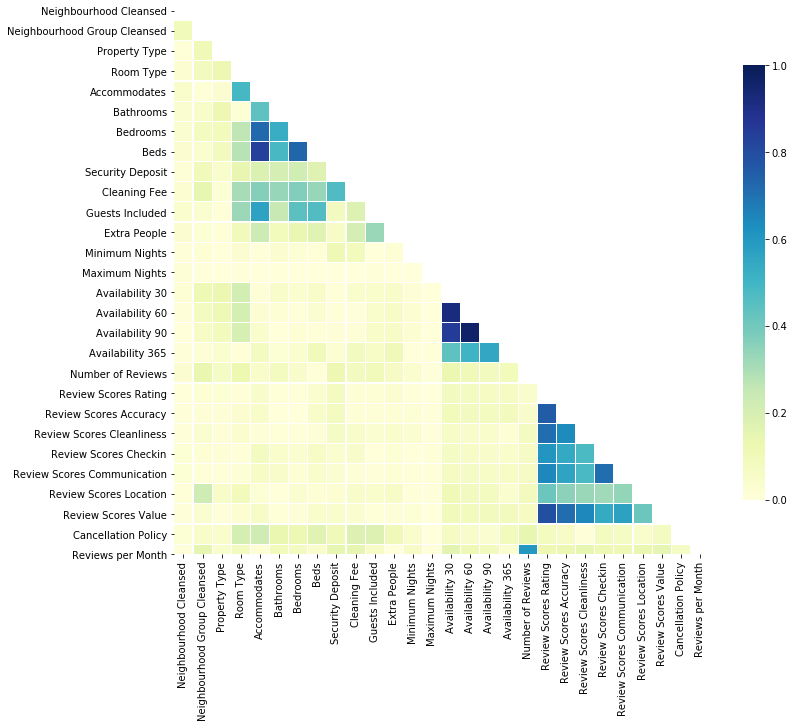

In [19]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Pintemos algunas variables

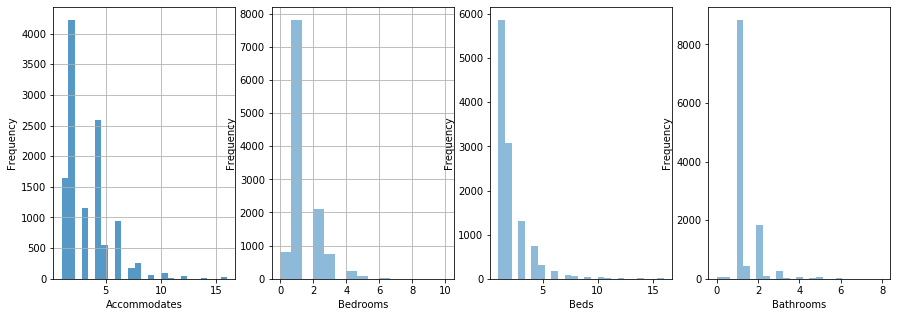

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
train['Accommodates'].plot.hist(alpha=0.75, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,4,2)
train['Bedrooms'].plot.hist(alpha=0.5, bins=15, grid = True)
plt.xlabel('Bedrooms')

plt.subplot(1,4,3)
train['Beds'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Beds')

plt.subplot(1,4,4)
train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Bathrooms')

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month

In [21]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11824, 16)

## Separacion variable dependiente 
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [22]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


El siguiente paso es aplicar los metodos de filtrados para regresion, pero esto solo se pueden aplicar sobre variables que no contienen valores NaN.
por tanto analicemos que variables tienen valores NaN y llevemos a cabo el proceso de imputacion, aprovechare para analizar algun posible outlier

Para hacerlo vamos a aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(X_train['campo'].unique()))
print(X_train['campo'].isna().sum())
print(X_train['campo'].value_counts())

```

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media (1.3)
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos la media (32)
- Review Scores Rating (2651). Imputamos la mediana (77) ya que la media esta demasiado cerca de la mejor puntuacion.

In [23]:
X_train.drop('Security Deposit', axis=1, inplace=True)

In [24]:
X_train['Bathrooms'] = train['Bathrooms'].fillna(1.3)
X_train['Cleaning Fee'] = train['Cleaning Fee'].fillna(32)
X_train['Review Scores Rating'] = train['Review Scores Rating'].fillna(77)

## Variable objetivo
Por ultimo analizamos la variable objetivo

In [25]:
y_train.describe()

count    11810.000000
mean        73.702794
std         72.203846
min          9.000000
25%         34.000000
50%         55.000000
75%         87.000000
max        999.000000
Name: Price, dtype: float64

In [26]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

348
14
50.0     513
60.0     441
30.0     437
25.0     433
35.0     381
        ... 
356.0      1
252.0      1
154.0      1
222.0      1
434.0      1
Name: Price, Length: 347, dtype: int64
73.70279424216766


In [27]:
y_train = y_train.fillna(74)

In [28]:
X_train

,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Property Type,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Maximum Nights,Availability 30,Number of Reviews,Review Scores Rating,Cancellation Policy
2472,19,15,0,1,1,1.0,32.0,0,1,1125,29,0,77.0,3
12299,37,3,0,0,4,1.0,15.0,0,1,1125,15,20,91.0,1
4024,36,2,0,0,7,1.0,32.0,15,2,1125,12,3,80.0,3
12692,13,3,0,1,2,3.0,32.0,0,10,1125,0,0,77.0,3
11228,15,5,0,1,2,1.0,32.0,10,1,1125,7,97,92.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,3,11,0,0,3,1.0,16.0,0,3,1125,2,0,77.0,2
3264,26,11,0,0,6,2.5,32.0,0,14,30,0,0,77.0,1
9845,28,3,0,0,2,1.0,30.0,40,1,1125,10,24,94.0,3
10799,28,3,0,0,2,1.0,25.0,0,2,15,14,19,98.0,3


## Filtrado para regresion
Con las 13 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [29]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

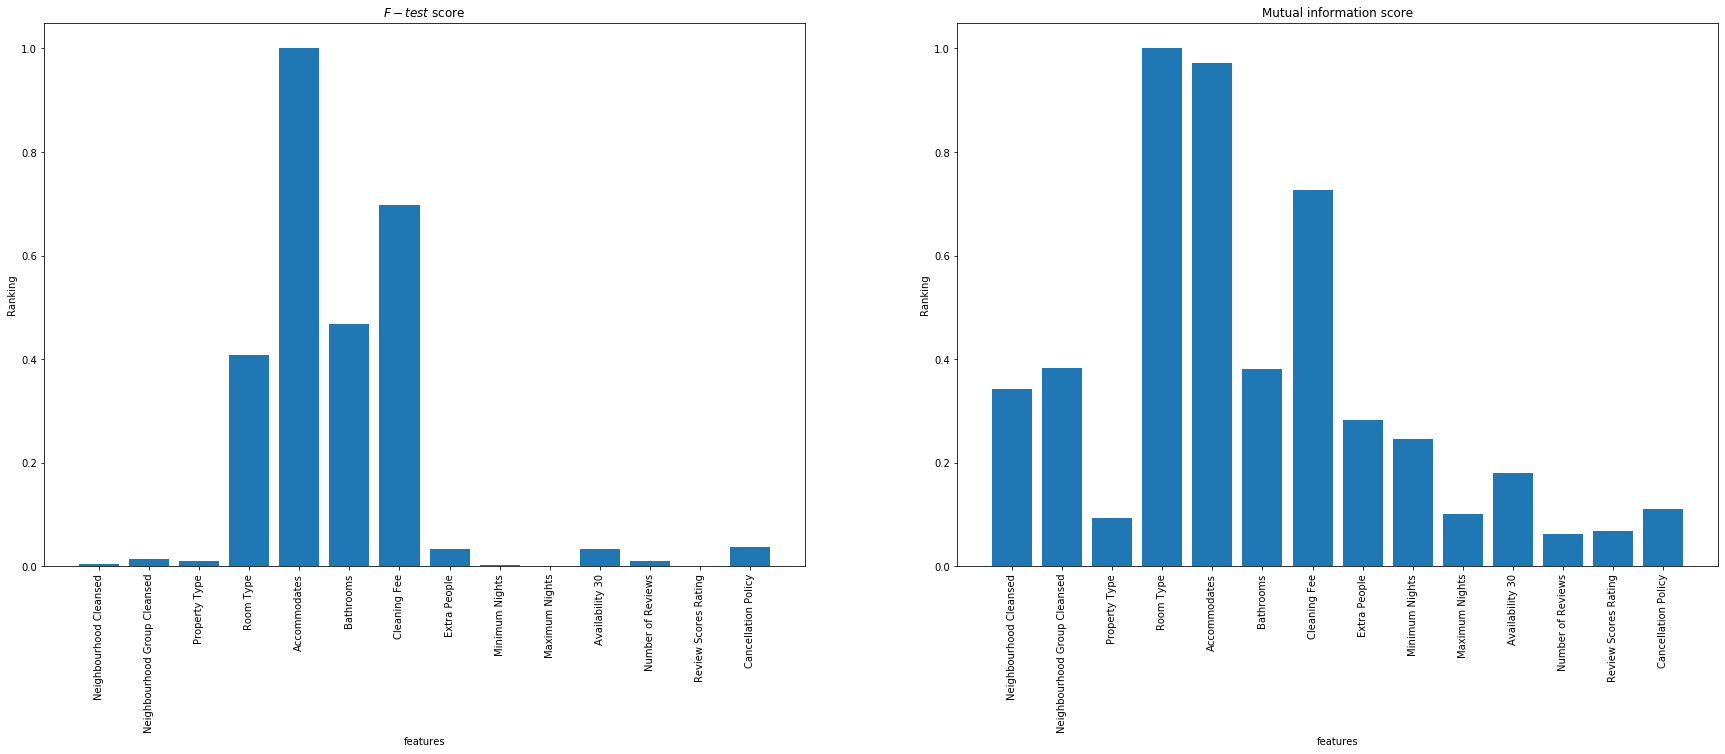

In [30]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Group Cleansed
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [31]:
drop_filtrado = ['Neighbourhood Cleansed', 'Property Type', 'Extra People', 'Minimum Nights', 'Maximum Nights', 
                 'Availability 30', 'Number of Reviews', 'Review Scores Rating', 'Cancellation Policy']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [32]:
X_train.rename(columns={'Neighbourhood Group Cleansed':'Barrio'}, inplace=True)

In [33]:
X_train.describe()

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee
count,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000
mean,6.759726,0.405616,3.276641,1.286494,32.089648
std,5.490015,0.517205,2.106127,0.666088,24.586216
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,1.000000,20.000000
50%,3.000000,0.000000,3.000000,1.000000,32.000000
75%,13.000000,1.000000,4.000000,1.000000,32.000000
max,20.000000,2.000000,16.000000,8.000000,662.000000


## Normalizacion
Por ultimo llevamos a cabo el escalado mediante StandarEscales
Recordemos que para test deberemos usar el scaler obtenido en train


In [34]:
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Prueba de Modelos

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el dataset de Test con las mismas transformaciones que hemos llevado a cao sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): encoder_room_type y encoder_neigh_group
- Tratamiento de NaNs: Bathroom y Cleaning Fee


In [38]:
test.shape

(2956, 29)

In [74]:
#Dropeamos
test_tmp = test[:]
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit y la variable target
test.drop('Security Deposit', axis=1, inplace=True)
test.drop('Price', axis=1, inplace=True)

#Aplicamos el encoder (es un replace no un nuevo labelEncoder)
num_encoder_room_type = list(range(0,len(encoder_room_type)))
test['Room Type'] = test['Room Type'].replace(encoder_room_type, num_encoder_room_type)

num_encoder_neigh_group = list(range(0,len(encoder_neigh_group)))
test['Neighbourhood Group Cleansed'] = test['Neighbourhood Group Cleansed'].replace(encoder_neigh_group, num_encoder_neigh_group)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(1.3)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(32)

#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Group Cleansed':'Barrio'}, inplace=True)

print(test.shape)
print(test)

(2956, 5)
      Barrio  Room Type  Accommodates  Bathrooms  Cleaning Fee
9612      20          1             1        1.0           5.0
4447       3          0             2        1.0          32.0
8936       5          0             2        1.0          20.0
4006      10          1             1        0.5          32.0
13853      3          0             3        1.0          32.0
...      ...        ...           ...        ...           ...
5344       6          1             1        1.0          32.0
9901       3          0             2        1.0          32.0
11630      2          1             1        1.0          32.0
7417       3          0             5        1.5          40.0
12143      2          0             6        2.0          40.0

[2956 rows x 5 columns]


Vayamos ahora con la prueba de modelos